# Fundamentals of Machine Learning
> ## Session 3: Neural Networks

----

#### Importing Dependencies

---

In [5]:
import torch
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, ToPILImage


### Introducing the Data
------
For this section of the notebook we're going to use the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. 

In short, it's a dataset of handwritten digits.

- There are 60,000 training images and 10,000 testing images.

- Each image represents a single handwritten digit.

- There are 10 classes of digit, ranging from 0 to 9.

- All images have been scaled to be 28x28 pixels.

---- 

MNIST is a very famous dataset that has been used for [benchmarking](https://paperswithcode.com/sota/image-classification-on-mnist) the performance of image classifiers for well over a decade. 

As such, many deep learning libraries have a convenient implementation to help access the dataset. 

Here's how we can quickly get a training and testing set using PyTorch.

----

In [6]:
# Load in the training set
train_data = datasets.MNIST(        # PyTorch has a custom MNIST object to help with getting data into your Python code
    root='data',                    # sets the directory (folder) where the data should be saved
    train=True,                     # determines whether we are pulling the 60k training images or the 10k test images
    download=True,                  # determines if the data should be downloaded or just kept in your PCs Random Access Memory
    transform=ToTensor()            # determines how the data should be represented - in this case directly as a tensor
    )

# Load the testing set
test_data = datasets.MNIST(         
    root='data',                    
    train=False,                    
    download=True,                  
    transform=ToTensor()            
    )

----

We have our train and test sets with two simple commands! 

Unlike the numpy arrays and DataFrames we have worked with in the past, there are some other things packaged with the MNIST datasets. 

Let's see what we can unpack from the _training set_ them.

---

In [7]:
# Get the number of training samples
n_train_samples = train_data.data.shape[0]

# Get the number of testing samples
n_test_samples = test_data.data.shape[0]

# Get the image dimensions for all samples
features = (train_data.data.shape[1], train_data.data.shape[2])

# Get the number of unique classes within the training data
n_classes = len(torch.unique(train_data.targets))

# Determine which numeric ID refers to which class
class_map = train_data.classes


print(f"Training set has: {n_train_samples} samples")
print(f"Testing set has: {n_test_samples} samples\n")
print(f"> Each sample is {features[0]} by {features[1]} pixels")
print(f"> In other words, each sample has {features[0] * features[1]} features")
print(f"> Each sample belongs to 1 of {n_classes} classes")
print(f"> Each class has a unique ID to represent a unique digit. ")
print(f"> These are:")
for pair in class_map:
    print(f"\t{pair}")

Training set has: 60000 samples
Testing set has: 10000 samples

> Each sample is 28 by 28 pixels
> In other words, each sample has 784 features
> Each sample belongs to 1 of 10 classes
> Each class has a unique ID to represent a unique digit. 
> These are:
	0 - zero
	1 - one
	2 - two
	3 - three
	4 - four
	5 - five
	6 - six
	7 - seven
	8 - eight
	9 - nine


#### Configuring the DataLoader
-----
As deep learning libraries increased in popularity, many of them adopted convenient ways to interact with datasets. 

Those interactions rarely change between different machine learning tasks. 

Often we want to iteratively:
- shuffle samples to change their order

- grab batches of data to update or test the model

- perform prediction over collections of test data

- calculate errors across a batch of data

... etc. 

In PyTorch, we can use a DataLoader to do just this. DataLoaders "wrap" around our datasets to make these interactions simpler.

----

##### The Batch

One thing we haven't talked about is the notion of a **batch**.

a batch refers to the number of samples a network processes before the model’s internal parameters are updated.

The idea is: updating a model's idea of what constitutes a class based on a small number of images might be a little premature.

Batch training means we can provide the model with a 'fairer' representation of the data before it gets adjusted.

There are different types of [batch sizes](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU), but this is the general idea.

---

Let's see how they're used with the DataLoader. 

----

In [8]:
# Set the number of datapoints to sample at once from our dataset
batch_size = 64

# Wrap a "Data loader" around our training and test sets for convenience
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

In [9]:
# Loop once over the DataLoader just to see how features and labels are sampled from it
for X, y in train_loader:
    print(f"Each iteration over the DataLoader produces:") 
    print(f"* Feature data in the form: {X.shape}")
    print(f"* Label data in the form {y.shape}\n")
    print(f"This means, for every loop over the DataLoader, we get:")
    print(f"> {X.shape[0]} images")
    print(f"> {X.shape[2] * X.shape[3]} pixels (features) for every {X.shape[1]} image")
    print(f"> {y.shape[0]} labels describing which class (handwritten digit) those features belong to.")
    break

Each iteration over the DataLoader produces:
* Feature data in the form: torch.Size([64, 1, 28, 28])
* Label data in the form torch.Size([64])

This means, for every loop over the DataLoader, we get:
> 64 images
> 784 pixels (features) for every 1 image
> 64 labels describing which class (handwritten digit) those features belong to.


#### Showing the images

---

Seeing image data as a set of floating point numbers doesn't really resonate with humans, but it's how predictive models like to process data.

Fortunately for us, there are ways to plot these images to make them appear familiar to us.

Not only does it help us understand what the data looks like, but can be a useful sanity check when debugging our code.

Here's a function that can help us inspect the first $N$ images of a given dataset.

---

In [10]:
def show_images(dataset, rows, cols):
    """
    Function takes a dataset, a number of rows and a number of columns to
    plot a grid of the first {row * cols} images within the specified dataset. 
    
    """
    to_pil_image = ToPILImage()
    n_images = rows * cols
    images = [to_pil_image(x_data) for x_data in dataset[:n_images]]
    
    _, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    for i, img in enumerate(images):
        ax = axes[i // cols, i % cols]
        ax.imshow(img)
        ax.axis('off')  # Turn off axes
    plt.tight_layout()
    plt.show()

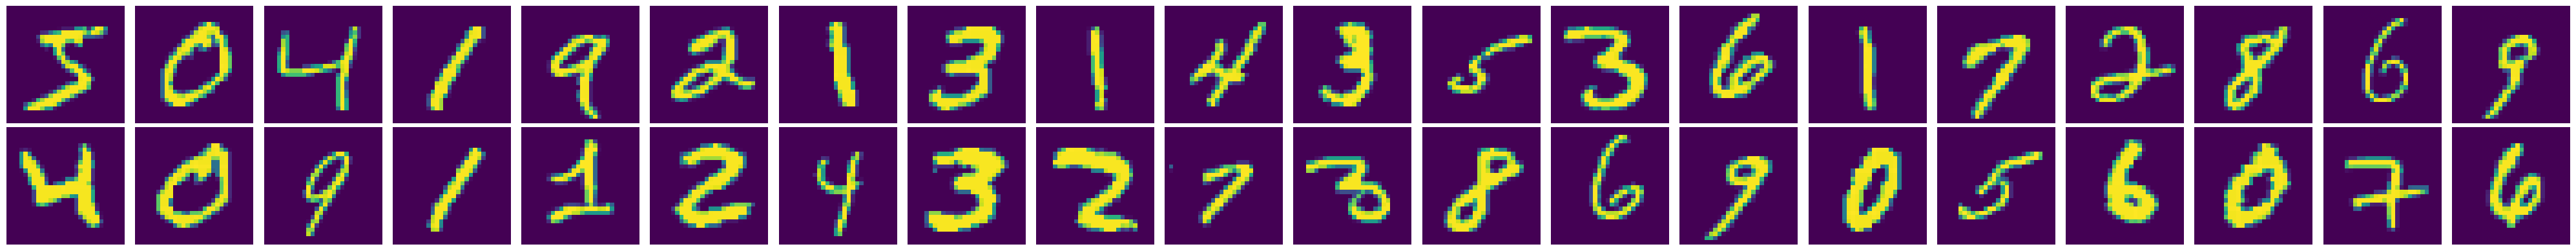

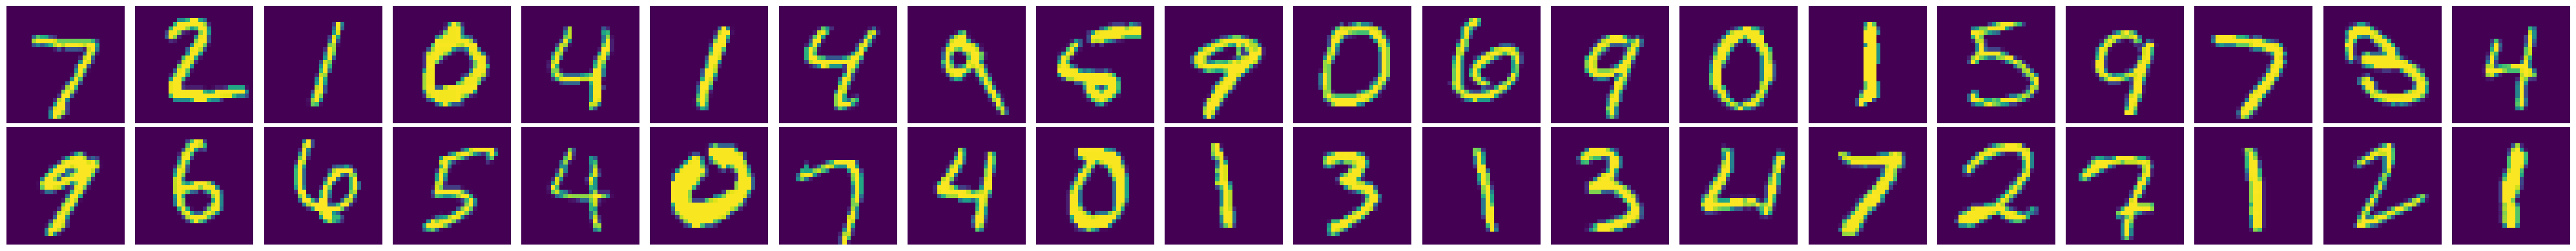

In [11]:
# Choose a number of images to plot
n_rows = 2                    # TODO: Choose number of rows to plot (must be  > 1)
n_columns = 20                  # TODO: Choose number of columns to plot
n_images = n_rows * n_columns
x_train = train_data.data
x_test = test_data.data

show_images(x_train, n_rows, n_columns)
show_images(x_test, n_rows, n_columns)

See? 

We can throw raw pixel data into a graphical library and generate digital images of these handwritten digits.

All a neural network needs to distinguish between them is the same raw pixels and a set of labels to tell it which digit describes each set of pixels.

----

#### Network Architecture
-----

A neural network's architecture refers to the structured layout and composition of its _layers_.

At its most basic, this refers to the number of layers, as well as the number of _neurons_ that make up those layers.

A neural net can also use different [_types_](https://pytorch.org/docs/stable/nn.html) of layers and neurons to solve different problems in deep learning.

Architecture also refers to how these layers are _connected_.

It defines how data flows through the network, from the input layer to the output layer, determining how the network transforms input data into output predictions.

----

##### Layers!

You have probably seen an image like the one below depicting a neural network.

![image](https://images.spiceworks.com/wp-content/uploads/2022/05/18113202/The-Architecture-of-a-Neural-Network.png)

A neural net must have at least _three_ layers. 
- __An input layer__ , sometimes called a __feature layer__, pulls in the data's features and maps them to the first _hidden layer_

- __A hidden layer__  receives data, either from the input layer or some preceding hidden layer, and passes it to either the next hidden layer or the _output layer_

- __An output layer__ receives data from the final hidden layer and assigns a probability to all of the output neurons. The neuron with the highest value is considered the 'prediction'

---- 
##### Connections
In code, a  key choice one must make when designing a network is how many _connections_ a single layer shares with its neighbouring layers.

**Note**:
> The idea is to learn the most _important features_ for our prediction and ignore the redundant information.

> To that end, _hidden layers tend to be smaller than the input layer_ since it forces our model to sacrifice useless information!

----

In the following section we see how one can use PyTorch to bring these concepts of neurons, layers and connections together.

In [12]:
def get_model(input_size, output_size):
    """
    Function returns a simple feed-forward neural network.
    The input size will be the number of pixels in a single image.
    The output size will be the number of classes we can possibly predict.
    """
    model = nn.Sequential(nn.Flatten(),                 # This layer automatically reduces any input into a 1-dimensional vector 
                        nn.Linear(input_size, 512),     # (technically the input layer) takes the flattened image and condenses it for the first hidden layer
                        nn.ReLU(),                      # This defines the activation function between the previous and next layer
                        nn.Linear(512, 512),            # This is the first hidden layer, taking the condensed representation of the image and passing it to the output layer
                        nn.ReLU(),                      # Yet another activation function between the hidden and output layers
                        nn.Linear(512, output_size))    # The output layer, which takes the condensed representation of the image and maps it to the 10 classes of digits
    return model

In [13]:
# Flatten an image (turn it from a matrix of pixels into a vector of pixels) and get its size
in_size = X[0].flatten().shape[0]

# Set the output size as the number of classes we can try to predict (the number of unique digits)
out_size = n_classes

# Check to see the number of input neurons and output neurons
print(f"The neural network will use:")
print(f"> {in_size} input neurons")
print(f"> {out_size} output neurons")

neural_net = get_model(in_size, out_size)
print(f"> the following architecture: \n{neural_net}")

The neural network will use:
> 784 input neurons
> 10 output neurons
> the following architecture: 
Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=512, bias=True)
  (2): ReLU()
  (3): Linear(in_features=512, out_features=512, bias=True)
  (4): ReLU()
  (5): Linear(in_features=512, out_features=10, bias=True)
)


In [14]:
def train(dataloader, model, loss_fn, optimiser): 
    """
    Function to manage the core training loop of the neural network.
    Every time it's called, a batch of data will be pulled from the {dataloader} and 
    used to form predictions using the specified {model}. 
    The collective predictions will produce errors using the {loss_fn}. 
    These erorrs, or losses, are passed back through the model, where the model's 
    parameters will be adjusted using the {optimiser}.

    """
    size = len(dataloader.dataset)
    
    # Set the model to training mode 
    model.train() 
    for batch_number, (X, y) in enumerate(dataloader):
        
        # Compute predictions
        y_pred = model(X)

        # Calculate loss from predictions and ground truth
        loss = loss_fn(y_pred, y)

        # Pass the errors back through the neural net
        loss.backward()

        # Make a single optimiser step (model parameter adjustment)
        # The magnitude of this adjustment depends on the learning rate
        optimiser.step()

        # Reset the gradients of all tensors being optimised
        optimiser.zero_grad()

        # Show training results every 100 batches
        if batch_number % 200 == 0:
            loss, current = loss.item(), (batch_number + 1) * len(X)
            print(f"| loss : {loss:.7f} [{current:>5}/{size:>5d}]")

In [15]:
def test(dataloader, model, loss_fn):
    """
    Function takes a dataloader for the testing set, the model we want to test
    and the loss function used to measure the prediction errors against the 
    testing set.
    
    """
    # Determine the number of samples within the testing set 
    size = len(dataloader.dataset)

    # Determine the number of batches within the dataloader
    n_batches = len(dataloader)

    # Put the model into evaluation mode
    model.eval()

    # Initiate values for the loss and number of correct predictions
    loss, correct = 0, 0
    
    # Disable model optimisation (do not compute gradients of tensors)
    # We just want to pass data through the network, not update it.
    with torch.no_grad():
        
        # Grab a batch of data for testing
        for X, y in dataloader:

            # Performa a prediction over that batch
            y_pred = model(X)

            # Get the loss given the true label and predicted labe
            loss += loss_fn(y_pred, y).item()

            # If the output node with the largest (probability) value matches 
            # the ground truth, consider this a correct prediction.
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
        
        # Get the average loss across batches
        loss /= n_batches 

        # Get the proportion of correct predictions across all testing samples
        correct /= size
        print(f" {'-'*30}")
        print(f"| > Accuracy: {(100*correct):>0.1f}%")
        print(f"| > Average loss: {loss:>8f}")
        print(f" {'-'*30}")

#### Configuring Hyperparameters 

---

Before we continue there's an important distinction to make.

 That is what we mean by a neural network's _parameters_ and its _hyperparameters_.

---

##### 1. Parameters

> The _internal_ variables which are applied to input features and work with activation functions to generate the network's output.

> Typically, these include the neural network's:
- __weights__: coefficients multiplied with input features and intermediate neurons

- __biases__: constants values added to the (feature-weight) pair before they're passed an activation function

> They tend to start off as small random values and are learned *during* the training process.

----

##### 2. Hyperparameters

> Values which govern how a neural network's parameters are adjusted during training.

> They're (usually) selected *before* the neural network is built and any training takes place

> Typically, these include:
- __learning rate__

- number of __epochs__

- [__batch size__](https://wandb.ai/ayush-thakur/dl-question-bank/reports/What-s-the-Optimal-Batch-Size-to-Train-a-Neural-Network---VmlldzoyMDkyNDU)
- number of __layers__

- __neurons__

- [__activation function__](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6)

- [__loss function__](https://towardsdatascience.com/what-is-loss-function-1e2605aeb904)

etc


---

Let's see how these come together when defining our own training and evaluation loop

In [16]:
def train_test(model, epochs, train_loader, test_loader, loss_fn, optimiser):
    """
    Function uses the specified {loss function} and {optimiser}
    to train and test the specified {model} for the specified number 
    of {epochs}.

    """
    for e in range(epochs):
        print(f' {"_"*30}')
        print(f"| Epoch {e+1}")
        print(f'|{"_"*30}')
        train(train_loader, model, loss_fn, optimiser)
        test(test_loader, model, loss_fn)

    print("Done!")

In [17]:
model = get_model(in_size, out_size)

loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-3    # 0.001

optimiser = optim.SGD(model.parameters(), learning_rate)

epochs = 5

train_test(model= model,
            epochs= epochs,
            train_loader= train_loader,
            test_loader= test_loader, 
            loss_fn= loss_fn,
            optimiser= optimiser)

 ______________________________
| Epoch 1
|______________________________
| loss : 2.3074684 [   64/60000]
| loss : 2.2799842 [12864/60000]
| loss : 2.2809772 [25664/60000]
| loss : 2.2677696 [38464/60000]
| loss : 2.2567475 [51264/60000]
 ------------------------------
| > Accuracy: 47.8%
| > Average loss: 2.249759
 ------------------------------
 ______________________________
| Epoch 2
|______________________________
| loss : 2.2577450 [   64/60000]
| loss : 2.2370806 [12864/60000]
| loss : 2.2263196 [25664/60000]
| loss : 2.1990845 [38464/60000]
| loss : 2.1849232 [51264/60000]
 ------------------------------
| > Accuracy: 60.2%
| > Average loss: 2.175239
 ------------------------------
 ______________________________
| Epoch 3
|______________________________
| loss : 2.1870117 [   64/60000]
| loss : 2.1692505 [12864/60000]
| loss : 2.1391389 [25664/60000]
| loss : 2.0865426 [38464/60000]
| loss : 2.0666530 [51264/60000]
 ------------------------------
| > Accuracy: 64.6%
| > Avera

### Changing Hyperparameters

Some of the more complex hyperparameters have good implementations provided by PyTorch. 

You can essentially look them up, replace the ones in the code below, and rerun your training loop to see how performance changes.

Here are some to get you started:
- [loss functions](https://pytorch.org/docs/stable/nn.html#loss-functions) 

- [activation functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)

- [optimisers](https://pytorch.org/docs/stable/optim.html#algorithms)

**Note:** You'll need to change the activation function within the get_model function we defined above.

---

##### See how accurate you can make your model!

In [18]:
model = get_model(in_size, out_size)

# TODO: Change the loss function to change how errors are calculated
loss_fn = nn.CrossEntropyLoss()

# TODO: Change the learning rate to adjust the magnitude of each optimisation step
learning_rate = 1e-7    # 0.0000001

# TODO: Change the optimiser to adjust neural net parameters differently
optimiser = optim.Adamax(model.parameters(), learning_rate)


epochs = 10
for e in range(epochs):
    print("_"*30)
    print(f"| Epoch {e+1}")
    print("_"*30)

    train(train_loader, model, loss_fn, optimiser)
    test(test_loader, model, loss_fn)

print("Done!")

______________________________
| Epoch 1
______________________________
| loss : 2.3009417 [   64/60000]
| loss : 2.2973230 [12864/60000]
| loss : 2.3003101 [25664/60000]
| loss : 2.3004940 [38464/60000]
| loss : 2.3049462 [51264/60000]
 ------------------------------
| > Accuracy: 12.3%
| > Average loss: 2.298567
 ------------------------------
______________________________
| Epoch 2
______________________________
| loss : 2.2989912 [   64/60000]
| loss : 2.2959034 [12864/60000]
| loss : 2.2985160 [25664/60000]
| loss : 2.2985363 [38464/60000]
| loss : 2.3030753 [51264/60000]
 ------------------------------
| > Accuracy: 12.7%
| > Average loss: 2.296748
 ------------------------------
______________________________
| Epoch 3
______________________________
| loss : 2.2971158 [   64/60000]
| loss : 2.2944930 [12864/60000]
| loss : 2.2967193 [25664/60000]
| loss : 2.2965741 [38464/60000]
| loss : 2.3011942 [51264/60000]
 ------------------------------
| > Accuracy: 13.2%
| > Average los